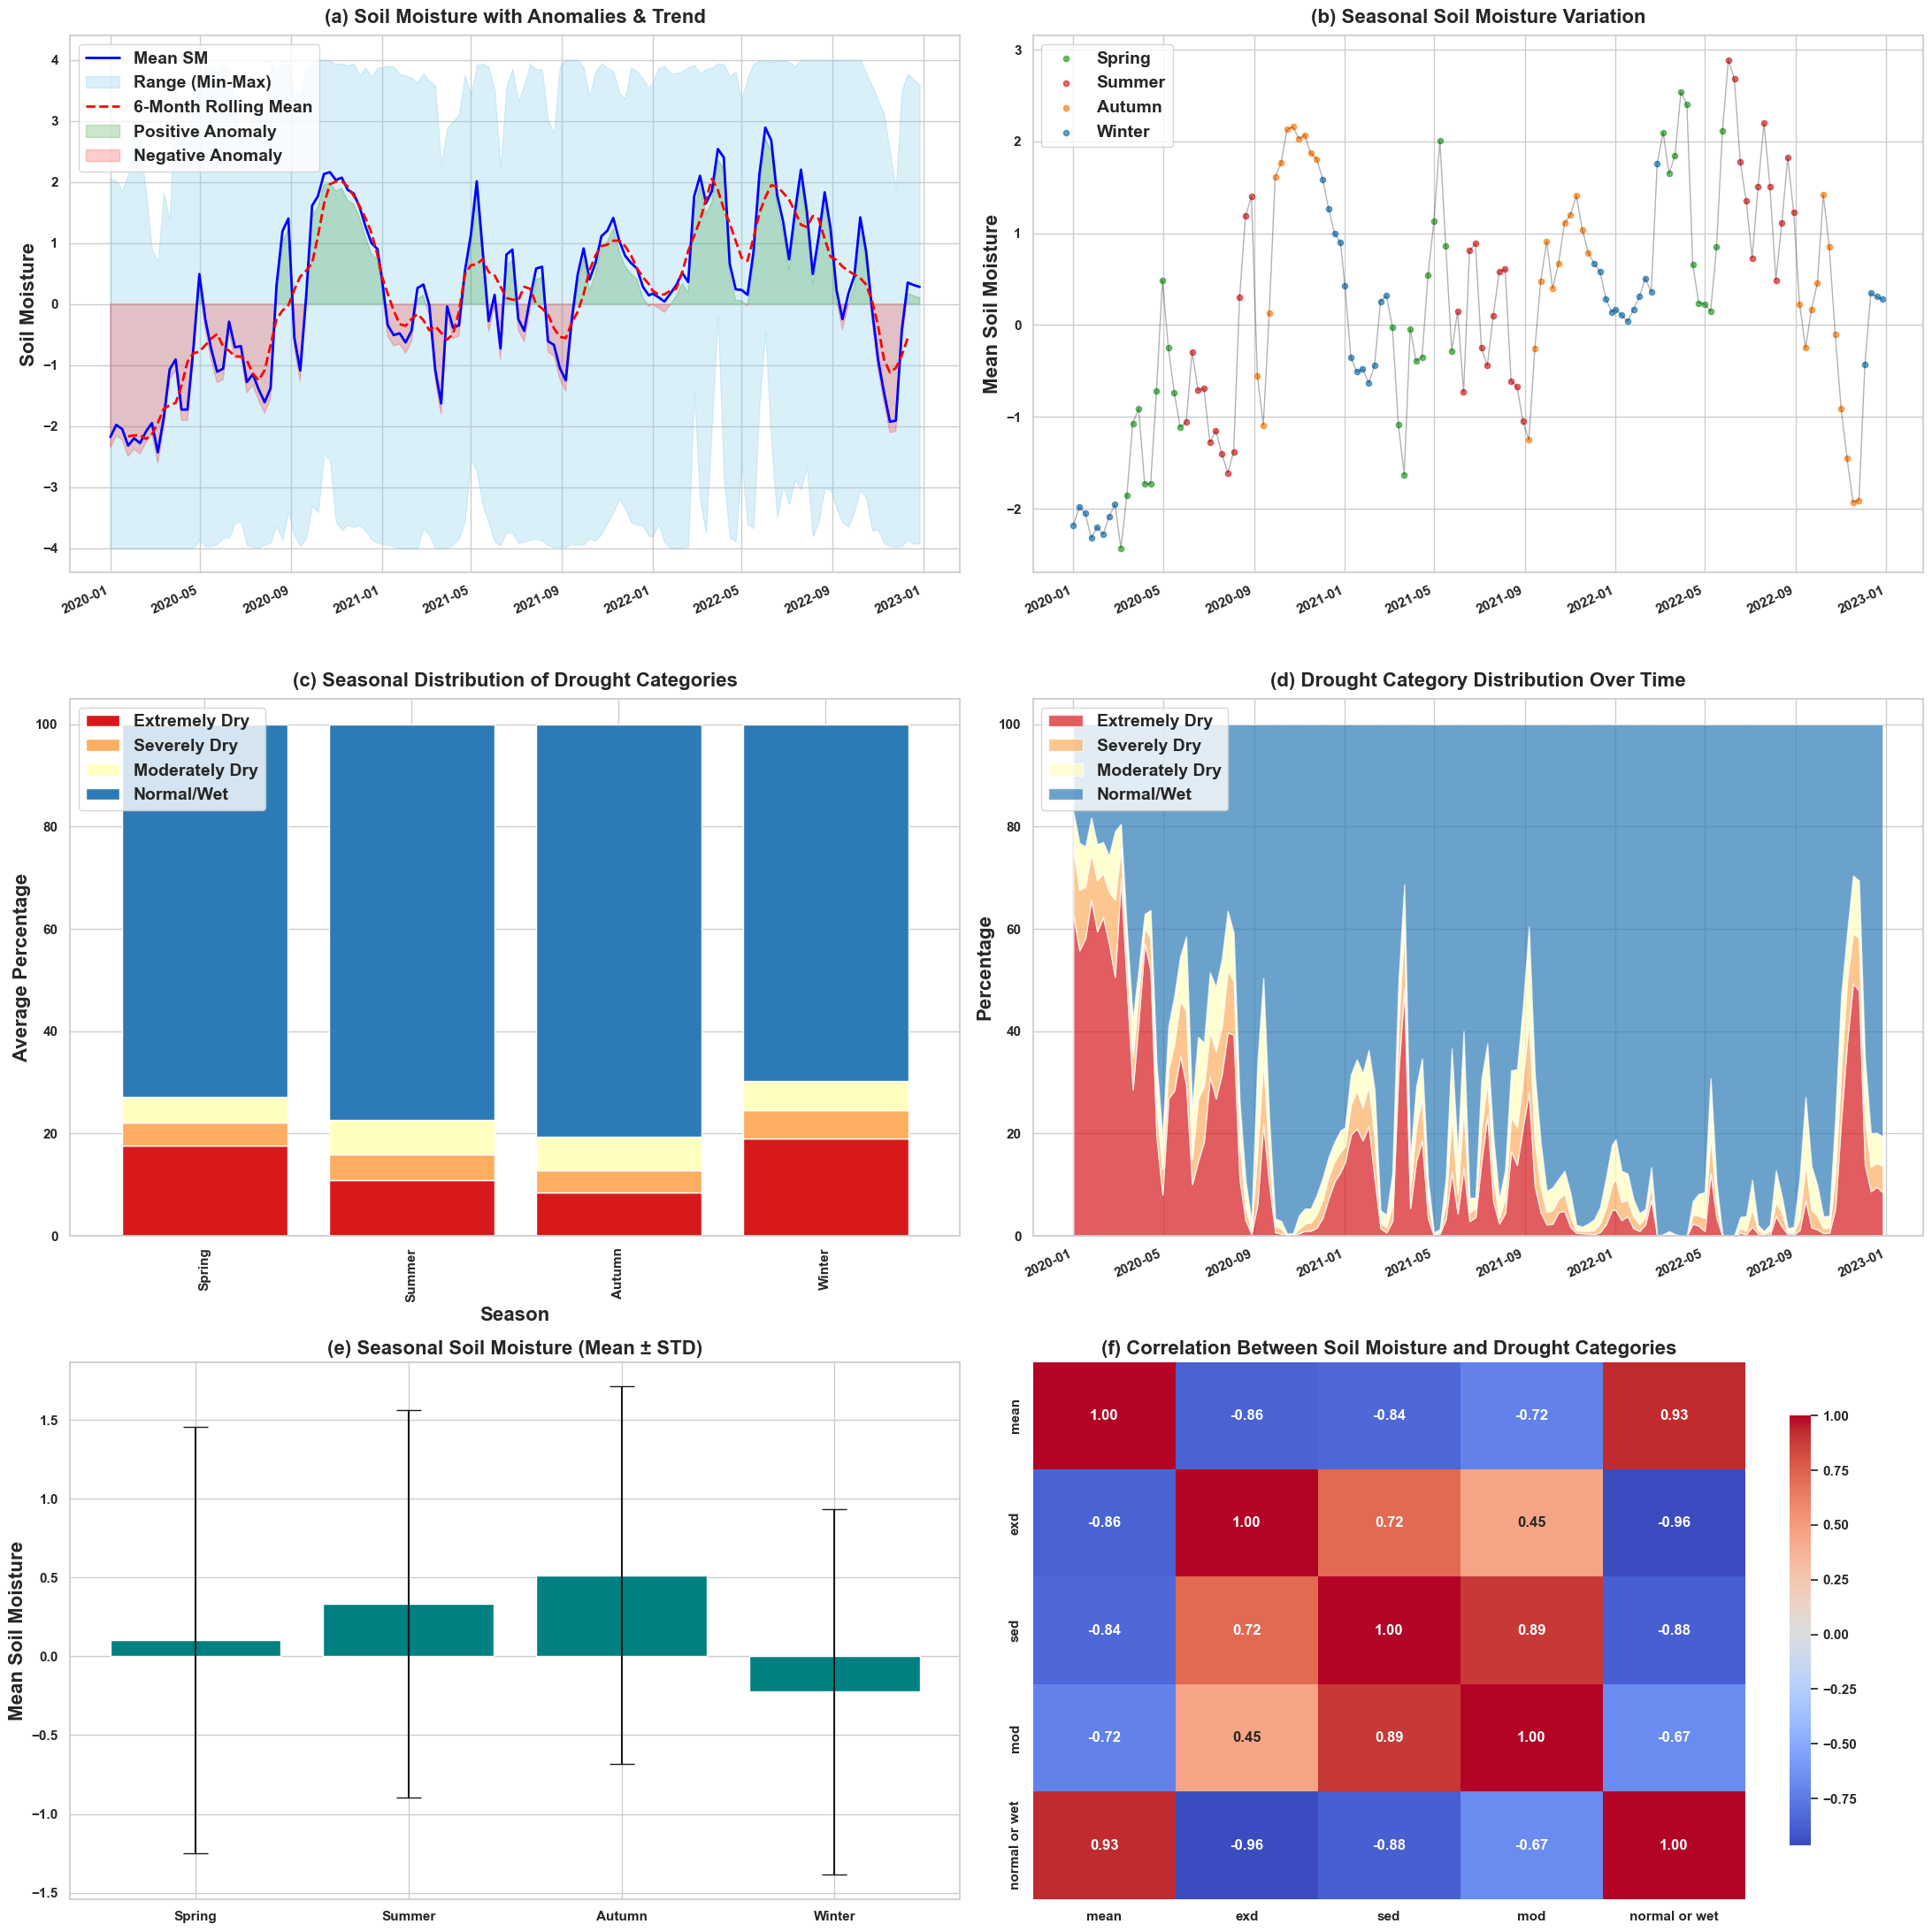

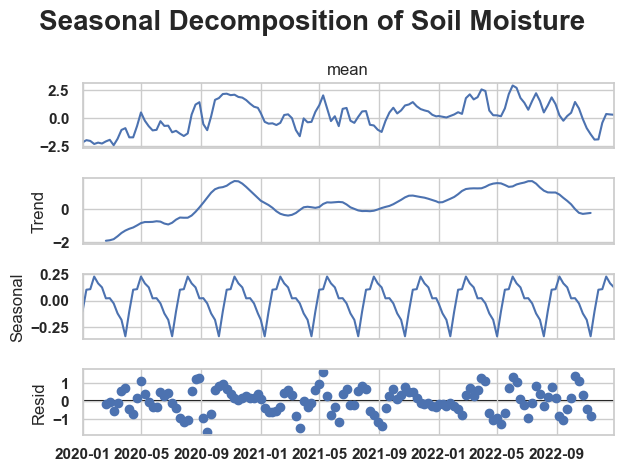

Seasonal Soil Moisture Stats:
         mean   std
season            
Spring  0.11  1.35
Summer  0.33  1.23
Autumn  0.52  1.20
Winter -0.22  1.16


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

# Set global style
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 18
sns.set(style="whitegrid")

# Load data
df = pd.read_csv('SMDI.csv', parse_dates=['date'])
df = df.sort_values(by='date')

# Add season
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

df['season'] = df['date'].apply(get_season)

# Add rolling mean and anomalies
df['rolling_mean'] = df['mean'].rolling(window=6, center=True).mean()
long_term_mean = df['mean'].mean()
df['anomaly'] = df['mean'] - long_term_mean

# Decompose time series
df.set_index('date', inplace=True)
decomp = seasonal_decompose(df['mean'], model='additive', period=12)
df.reset_index(inplace=True)

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(22, 22))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

# Plot 1: Time series with min/max, trend, and anomaly
ax1.plot(df['date'], df['mean'], label='Mean SM', color='blue', linewidth=2)
ax1.fill_between(df['date'], df['min'], df['max'], color='skyblue', alpha=0.3, label='Range (Min-Max)')
ax1.plot(df['date'], df['rolling_mean'], color='red', linestyle='--', linewidth=2, label='6-Month Rolling Mean')
ax1.fill_between(df['date'], 0, df['anomaly'], where=(df['anomaly'] > 0), interpolate=True, color='green', alpha=0.2, label='Positive Anomaly')
ax1.fill_between(df['date'], 0, df['anomaly'], where=(df['anomaly'] < 0), interpolate=True, color='red', alpha=0.2, label='Negative Anomaly')
ax1.set_title('(a) Soil Moisture with Anomalies & Trend', fontsize=16, fontweight='bold', pad=10)
ax1.set_ylabel('Soil Moisture', fontsize=16, fontweight='bold')
ax1.legend(loc='upper left', fontsize=14, frameon=True)

# Plot 2: Seasonal variation
seasonal_colors = {'Spring': '#2ca02c', 'Summer': '#d62728', 
                   'Autumn': '#ff7f0e', 'Winter': '#1f77b4'}

for season, color in seasonal_colors.items():
    subset = df[df['season'] == season]
    ax2.scatter(subset['date'], subset['mean'], color=color, label=season, alpha=0.7, s=20)

ax2.plot(df['date'], df['mean'], color='black', linewidth=1, alpha=0.3)
ax2.set_title('(b) Seasonal Soil Moisture Variation', fontsize=16, fontweight='bold', pad=10)
ax2.set_ylabel('Mean Soil Moisture', fontsize=16, fontweight='bold')
ax2.legend(loc='upper left', fontsize=14, frameon=True)

# Plot 3: Seasonal drought categories
categories = ['exd', 'sed', 'mod', 'normal or wet']
category_labels = ['Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Normal/Wet']
colors = ['#d7191c', '#fdae61', '#ffffbf', '#2c7bb6']

seasonal_drought = df.groupby('season')[categories].mean()
seasonal_drought = seasonal_drought.reindex(['Spring', 'Summer', 'Autumn', 'Winter'])
seasonal_drought.plot(kind='bar', stacked=True, color=colors, ax=ax3, width=0.8)
ax3.set_title('(c) Seasonal Distribution of Drought Categories', fontsize=16, fontweight='bold', pad=10)
ax3.set_ylabel('Average Percentage', fontsize=16, fontweight='bold')
ax3.set_xlabel('Season', fontsize=16, fontweight='bold')
ax3.legend(labels=category_labels, loc='upper left', fontsize=14, frameon=True)

# Plot 4: Stacked area chart of drought over time
ax4.stackplot(df['date'], df['exd'], df['sed'], df['mod'], df['normal or wet'],
              labels=category_labels, colors=colors, alpha=0.7)
ax4.set_title('(d) Drought Category Distribution Over Time', fontsize=16, fontweight='bold', pad=10)
ax4.set_ylabel('Percentage', fontsize=16, fontweight='bold')
ax4.legend(loc='upper left', fontsize=14, frameon=True)

# Plot 5: Seasonal mean ± std bar chart
seasonal_stats = df.groupby('season')['mean'].agg(['mean', 'std']).reindex(['Spring', 'Summer', 'Autumn', 'Winter'])
ax5.bar(seasonal_stats.index, seasonal_stats['mean'], yerr=seasonal_stats['std'], capsize=10, color='teal')
ax5.set_title('(e) Seasonal Soil Moisture (Mean ± STD)', fontsize=16, fontweight='bold')
ax5.set_ylabel('Mean Soil Moisture', fontsize=16, fontweight='bold')

# Plot 6: Correlation heatmap
corr = df[['mean', 'exd', 'sed', 'mod', 'normal or wet']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax6, cbar_kws={'shrink': 0.8})
ax6.set_title('(f) Correlation Between Soil Moisture and Drought Categories', fontsize=16, fontweight='bold')

# Format date axes
date_format = DateFormatter("%Y-%m")
for ax in [ax1, ax2, ax4]:
    ax.xaxis.set_major_formatter(date_format)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right")

# Adjust layout
plt.tight_layout()

# Save figure
output_path = r'C:\Users\ketsa\OneDrive\Documents\paper7_drougth\image\SMDI_deep_analysis.png'
plt.savefig(output_path, dpi=330)

# Show plot
plt.show()

# Optional: Decomposition plot
decomp.plot()
plt.suptitle('Seasonal Decomposition of Soil Moisture', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Optional: Print seasonal stats
print("Seasonal Soil Moisture Stats:\n", seasonal_stats.round(2))


In [ ]:
#continue analysis

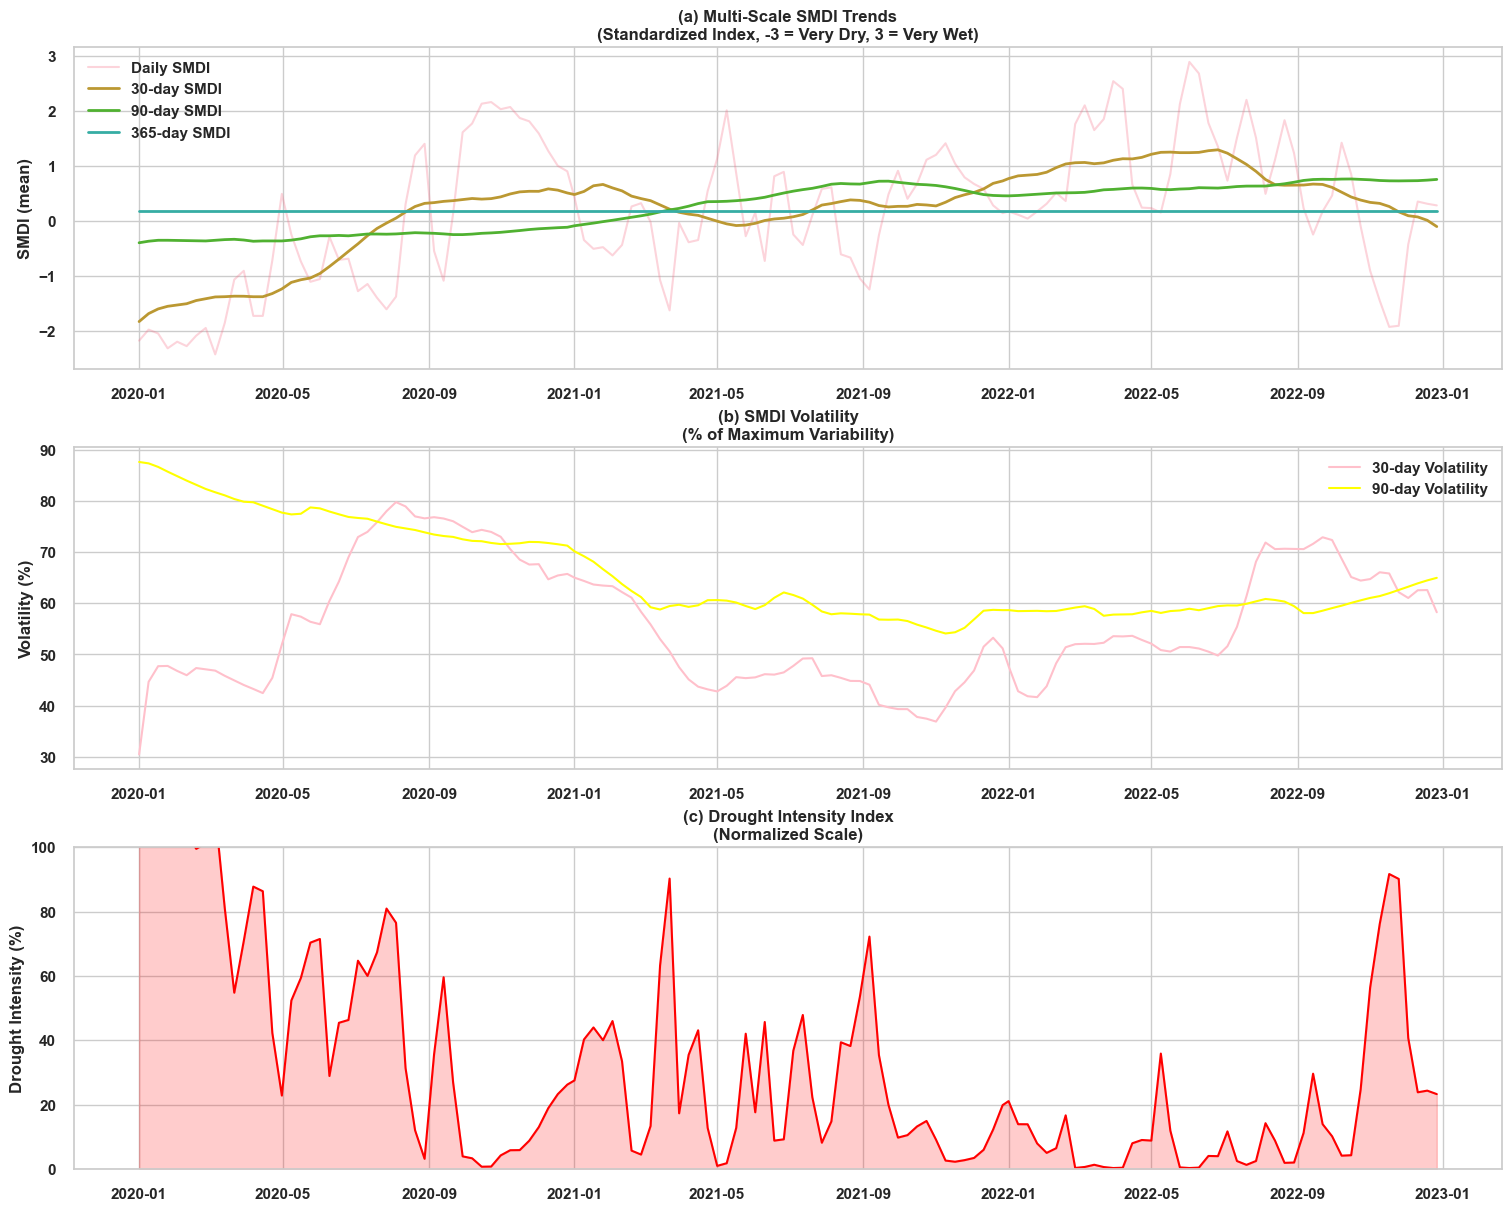


=== Stationarity Tests ===
ADF Test: Statistic=-3.386, p-value=0.011
KPSS Test: Statistic=0.689, p-value=0.015
Seasonal decomposition failed: x must have 2 complete cycles requires 730 observations. x only has 138 observation(s)


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the directory where images will be saved
output_dir = r'C:\Users\ketsa\OneDrive\Documents\paper7_drougth\image'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

## Updated Configuration
plt.style.use('seaborn-v0_8')  # Modern equivalent of 'seaborn'
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.weight': 'bold',
    'font.size': 26,
    'axes.titlesize': 26,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'figure.titlesize': 26,
    'figure.titleweight': 'bold',
    'xtick.labelsize': 26,  
    'ytick.labelsize': 26 
})
sns.set_theme(style="whitegrid", palette="husl")

## Data Loading and Preparation
try:
    df = pd.read_csv('SMDI.csv', parse_dates=['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Enhanced seasonal features
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12,1,2] else 
                                          'Spring' if x in [3,4,5] else
                                          'Summer' if x in [6,7,8] else 'Autumn')

    # Advanced rolling statistics
    windows = [30, 90, 365]  # 1-month, 3-month, and annual windows
    for w in windows:
        df[f'rolling_mean_{w}'] = df['mean'].rolling(window=w, center=True, min_periods=1).mean()
        df[f'rolling_std_{w}'] = df['mean'].rolling(window=w, center=True, min_periods=1).std()

    # Normalize volatility as a percentage
    max_possible_std = 1.73  # Approximate maximum standard deviation for SMDI range [-3, 3]
    df['volatility_30_percent'] = (df['rolling_std_30'] / max_possible_std) * 100
    df['volatility_90_percent'] = (df['rolling_std_90'] / max_possible_std) * 100

    # Drought intensity index
    df['drought_intensity'] = (0.4*df['exd'] + 0.3*df['sed'] + 0.2*df['mod'] + 0.1*(1-df['normal or wet']))

    # Normalize drought intensity as a percentage
    df['drought_intensity_percent'] = ((df['drought_intensity'] + 10) / 35) * 100  # Scale from [-10, 25] to [0, 100]

    ## Advanced Temporal Analysis (Figures a, b, c)
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), constrained_layout=True)

    # 1. Multi-scale trend analysis (Figure a)
    axes[0].plot(df['date'], df['mean'], label='Daily SMDI', alpha=0.3)
    axes[0].plot(df['date'], df['rolling_mean_30'], label='30-day SMDI', linewidth=2)
    axes[0].plot(df['date'], df['rolling_mean_90'], label='90-day SMDI', linewidth=2)
    axes[0].plot(df['date'], df['rolling_mean_365'], label='365-day SMDI', linewidth=2)
    axes[0].set_title('(a) Multi-Scale SMDI Trends\n(Standardized Index, -3 = Very Dry, 3 = Very Wet)')
    axes[0].set_ylabel('SMDI (mean)')  # Clarified that "mean" is SMDI
    axes[0].legend()

    # 2. Volatility analysis (Figure b)
    axes[1].plot(df['date'], df['volatility_30_percent'], label='30-day Volatility', color='pink')
    axes[1].plot(df['date'], df['volatility_90_percent'], label='90-day Volatility', color='yellow')
    axes[1].set_title('(b) SMDI Volatility\n(% of Maximum Variability)')
    axes[1].set_ylabel('Volatility (%)')  # Already in percentage
    axes[1].legend()

    # 3. Drought intensity (Figure c)
    axes[2].plot(df['date'], df['drought_intensity_percent'], color='red')
    axes[2].fill_between(df['date'], df['drought_intensity_percent'], color='red', alpha=0.2)
    axes[2].set_title('(c) Drought Intensity Index\n(Normalized Scale)')
    axes[2].set_ylabel('Drought Intensity (%)')  # Already in percentage
    axes[2].set_ylim(0, 100)  # Reflect percentage scale

    # Save the plot as an image
    plt.savefig(r'C:\Users\ketsa\OneDrive\Documents\paper7_drougth\image\Drought Intensity Index.png', dpi=330)
    plt.show()

    ## Stationarity and Seasonality Tests
    print("\n=== Stationarity Tests ===")
    # ADF Test
    adf_result = adfuller(df['mean'].dropna())
    print(f"ADF Test: Statistic={adf_result[0]:.3f}, p-value={adf_result[1]:.3f}")

    # KPSS Test
    kpss_result = kpss(df['mean'].dropna())
    print(f"KPSS Test: Statistic={kpss_result[0]:.3f}, p-value={kpss_result[1]:.3f}")

    # Seasonal decomposition with multiple periods (Figure d)
    try:
        decomp_annual = seasonal_decompose(df.set_index('date')['mean'].interpolate(), 
                                           model='additive', period=365, extrapolate_trend='freq')

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), constrained_layout=True)

        # Plot trend component
        decomp_annual.trend.plot(ax=ax1, title='(d) Seasonal Decomposition of SMDI\nTrend Component\n(Standardized Index)')
        ax1.set_ylabel('SMDI Trend (unitless)')  # Clarified that "mean" is SMDI

        # Plot seasonal component
        decomp_annual.seasonal.plot(ax=ax2, title='Seasonal Component\n(Periodic Fluctuations)')
        ax2.set_ylabel('SMDI Seasonal (unitless)')  # Clarified that "mean" is SMDI

        # Plot residual component
        decomp_annual.resid.plot(ax=ax3, title='Residual Component\n(Random Variations)')
        ax3.set_ylabel('SMDI Residual (unitless)')  # Clarified that "mean" is SMDI

        # Save the plot
        plt.savefig(os.path.join(output_dir, 'seasonal_decomposition.png'))
        plt.show()
    except Exception as e:
        print(f"Seasonal decomposition failed: {str(e)}")

    ## Interactive Visualization for Plotly (3D plot)
    if 'drought_regime' in df.columns:
        try:
            fig = px.scatter_3d(df.dropna(subset=['drought_regime']), 
                               x='date', y='mean', z='drought_intensity',
                               color='drought_regime', hover_data=['season'],
                               title='3D Soil Moisture-Drought Relationship')
            fig.update_layout(scene=dict(
                                xaxis_title='Date',
                                yaxis_title='SMDI (unitless)',
                                zaxis_title='Drought Intensity'))
            fig.write_image(os.path.join(output_dir, '3d_drought_regime.png'))
            fig.show()
        except Exception as e:
            print(f"3D plot failed: {str(e)}")

except FileNotFoundError:
    print("Error: The file 'SMDI.csv' was not found in the current directory.")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")